In [16]:
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd 
import os
image_dir = "/content/UTKFace/"
train_x = []
train_y = []

filename = []
gender=[]
race=[]
age=[]

for file in tqdm(os.listdir(image_dir),position=0,leave=True):
#     print(file)
#     img = cv2.imread(image_dir+file,0)
#     img = cv2.resize(img,(100,100))
#     img = img/255
    labels = file[:len(file)-13].split("_")
#     print(file)
#      = file
    if(len(labels)==4):
        filename.append(image_dir+file)
        gender.append(labels[1])
        race.append(labels[2])
        age.append(str((min(80,int(labels[0]))-min(80,int(labels[0]))%10)/10))
# train_x = np.array(train_x)
# train_y = np.array(train_y)
# train_x = train_x.reshape(23705,100,100,1)
# train_y = train_y.reshape(23705,3)

100%|██████████| 23708/23708 [00:00<00:00, 388746.21it/s]


In [17]:
data = pd.DataFrame(data=filename,columns=['filename'])
data['gender'] = gender
data['race'] = race
data['age'] = age
data['age']

0        8.0
1        2.0
2        0.0
3        2.0
4        4.0
        ... 
23700    1.0
23701    2.0
23702    2.0
23703    2.0
23704    2.0
Name: age, Length: 23705, dtype: object

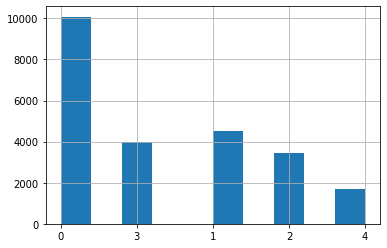

In [20]:
data['race'].hist()

In [18]:
from keras.preprocessing.image import ImageDataGenerator
image_width, image_height = 250, 250
nb_train_samples = 16000
nb_validation_samples = 7705
epochs = 30
batch_size = 64
train_datagen = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_dataframe(
    data.iloc[:nb_train_samples],
    directory=image_dir,
    x_col='filename',
    y_col='race',
    shuffle=False,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = test_datagen.flow_from_dataframe(
    data.iloc[nb_train_samples:],
    directory=image_dir,
    x_col='filename',
    y_col='race',
    shuffle=False,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse')

Found 16000 validated image filenames belonging to 5 classes.
Found 7705 validated image filenames belonging to 5 classes.


In [19]:
from tensorflow import keras
from keras.models import Sequential
from keras import layers,Input
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Dot

pretrained = keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=(image_width,image_height,3))
# pretrained.summary()
# for layer in pretrained.layers[-5:]:
#     layer.trainable = False
# for layer in pretrained.layers:
#     # layer.trainable = False
#     print(layer,layer.trainable)
model = Sequential()
model.add(pretrained)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(1e-3),
              metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
#     batch_size=1,
    verbose=1)

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 45,720,645
Trainable params: 45,720,645
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
250/250 [==============================] - 457s 2s/step - loss: 1.4636 - accuracy: 0.4047 - val_loss: 1.2782 - val_accuracy: 0.4951
Epoch 2/30
250/250 [==============

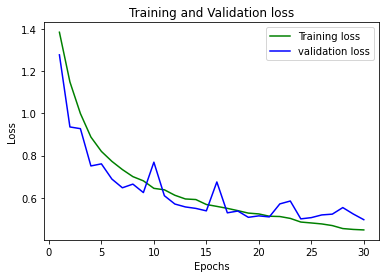

In [23]:
loss_train = history.history['loss']
# loss_train = history.history['train_loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

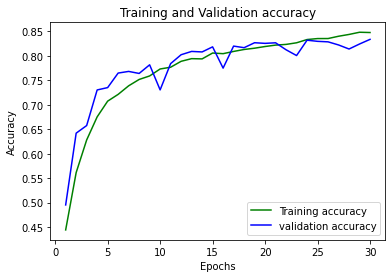

In [24]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()